In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load, dump
import shap
import time, psutil
import warnings
warnings.filterwarnings("ignore")

c:\Users\pawan_kumar4\Desktop\project2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("../datasets/Training.csv")

In [3]:
# Select sensor features
sensor_features = [
    'Accelerometer_X', 'Accelerometer_Y', 'Accelerometer_Z',
    'Gyroscope_X', 'Gyroscope_Y', 'Gyroscope_Z',
    'Magnetometer_X', 'Magnetometer_Y', 'Magnetometer_Z',
    'GPS_Speed',
    'Sound Level', 'Activity'
]

In [4]:
df = df[sensor_features]

In [ ]:
df.head()

In [ ]:
df.describe()

In [6]:
df.value_counts('Activity')

Activity
Bike        59665
Train       52801
Auto        52548
Metro       49722
Bus         45909
Car         30659
Standing    28037
Walking     25824
Name: count, dtype: int64

In [5]:
def extract_features(df, window_size=120, step_size=30):
    label_col = 'Activity'
    sensor_cols = [col for col in df.columns if col != label_col]

    features = []
    for start_idx in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[start_idx : start_idx + window_size]
        window_feats = {}

        # Calculate stats for each sensor column
        for col in sensor_cols:
            data = window[col].values
            window_feats.update({
                f"{col}_mean": np.mean(data),
                f"{col}_std": np.std(data),
                f"{col}_max": np.max(data),
                f"{col}_min": np.min(data),
                f"{col}_median": np.median(data),
                f"{col}_rms" : np.sqrt(np.mean(data**2)),
                f"{col}_range": np.max(data) - np.min(data),
                f"{col}_iqr": np.percentile(data, 75) - np.percentile(data, 25),
            })
        window_feats[label_col] = window[label_col].iloc[-1]
        features.append(window_feats)

    return pd.DataFrame(features)


In [6]:
agg_df = extract_features(df)

In [ ]:
agg_df.head()

In [7]:
# Split into features and target
X = agg_df.drop('Activity', axis=1)
y = agg_df['Activity']

In [8]:
le = LabelEncoder()
y = le.fit_transform(y)

In [9]:
dump(le, 'temp/label_encoder.pkl')

['temp/label_encoder.pkl']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,  # for reproducibility
    shuffle=True,     # shuffling the data
    stratify=y       # maintain class distribution
)
# Verify shapes
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")

Train: (9201, 88), (9201,)
Test: (2301, 88), (2301,)


In [11]:
dt_model = DecisionTreeClassifier(max_depth=8, random_state=42)
dt_model.fit(X, y)
dt_series = pd.Series(dt_model.feature_importances_, index=X.columns)
top_dt_cols = dt_series.sort_values(ascending=False).head(10)
print(top_dt_cols)

GPS_Speed_min          0.203845
Gyroscope_Z_iqr        0.167713
Sound Level_rms        0.120339
Accelerometer_Z_min    0.112833
Sound Level_median     0.070688
Gyroscope_X_iqr        0.049979
GPS_Speed_max          0.047926
Magnetometer_Y_min     0.032977
Magnetometer_Z_min     0.028286
Sound Level_max        0.020560
dtype: float64


In [12]:
top_dt_cols.index

Index(['GPS_Speed_min', 'Gyroscope_Z_iqr', 'Sound Level_rms',
       'Accelerometer_Z_min', 'Sound Level_median', 'Gyroscope_X_iqr',
       'GPS_Speed_max', 'Magnetometer_Y_min', 'Magnetometer_Z_min',
       'Sound Level_max'],
      dtype='object')

In [13]:
X_dt = X[top_dt_cols.index]

In [14]:
X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(
    X_dt, y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)
# Verify shapes
print(f"Train: {X_train_dt.shape}, {y_train_dt.shape}")
print(f"Test: {X_test_dt.shape}, {y_test_dt.shape}")

Train: (9201, 10), (9201,)
Test: (2301, 10), (2301,)


In [15]:
def plot_confusion_matrix(y_true, y_pred, tag, label_encoder=le):
    class_names = label_encoder.inverse_transform(np.unique(y_pred))
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{tag} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

In [16]:
def log_model(model,X_test,y_test,tag,label_encoder=le):
    print(f"\n=== {tag} ===")
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test,y_pred):.4f}")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"5-fold CV accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred,target_names=label_encoder.classes_))
    print("\nConfusion Matrix")
    plot_confusion_matrix(y_test,y_pred,tag)

In [17]:
def evaluate_model(model,X_train, y_train,X_test,  y_test,
                   tag,
                   P_idle=5.0,    # watts, your CPU’s idle power
                   P_peak=65.0):   # watts, your CPU’s max power
    """
    Trains `model` on (X_train, y_train), evaluates on (X_test, y_test),
    and returns timing, CPU usage, estimated energy, and accuracy.
    Energy is estimated as:
        P_avg = P_idle + cpu_util * (P_peak - P_idle)
        E_Wh  = P_avg * (wall_time_s / 3600)
    """
    proc = psutil.Process()

    # ----- TRAINING MEASUREMENT -----
    start_wall = time.perf_counter()
    cpu_start = proc.cpu_times()           # user+system at start

    model.fit(X_train, y_train)

    train_wall = time.perf_counter() - start_wall
    cpu_end = proc.cpu_times()
    train_cpu = ((cpu_end.user + cpu_end.system)
                 - (cpu_start.user + cpu_start.system))

    # Avoid division by zero
    train_util = train_cpu / train_wall if train_wall > 0 else 0.0
    P_train = P_idle + train_util * (P_peak - P_idle)
    E_train_Wh = P_train * (train_wall / 3600)

    # ----- PREDICTION MEASUREMENT -----
    start_wall = time.perf_counter()
    cpu_start = proc.cpu_times()

    y_pred = model.predict(X_test)

    test_wall = time.perf_counter() - start_wall
    cpu_end = proc.cpu_times()
    test_cpu = ((cpu_end.user + cpu_end.system)
                - (cpu_start.user + cpu_start.system))

    test_util = test_cpu / test_wall if test_wall > 0 else 0.0
    P_test = P_idle + test_util * (P_peak - P_idle)
    E_test_Wh = P_test * (test_wall / 3600)

    # ----- METRICS -----
    accuracy = accuracy_score(y_test, y_pred)

    results = {
        'model_variant': tag.split(':')[0],
        'n_features':    X_train.shape[1],
        'train_time_s':  train_wall,
        'train_cpu_s':   train_cpu,
        'train_energy_Wh': E_train_Wh,
        'test_time_s':   test_wall,
        'test_cpu_s':    test_cpu,
        'test_energy_Wh':  E_test_Wh,
        'accuracy':      accuracy
    }
    return results


In [18]:
def visualize_shap_per_class(model, X_train, label_encoder, top_n=10):
    class_labels = label_encoder.classes_

    # Use SHAP's unified interface for better compatibility
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train)
    
    for i, class_name in enumerate(class_labels):
        print(f"Class: {class_name}")

        # SHAP values for this class
        class_shap_values = shap_values[:, :, i]  # shape: (samples, features)

        # Mean absolute SHAP for each feature
        mean_shap = np.abs(class_shap_values).mean(axis=0)

        # Top N features
        top_indices = np.argsort(mean_shap)[::-1][:top_n]
        top_features = X_train.columns[top_indices]
        top_values = mean_shap[top_indices]

        # Plot
        plt.figure(figsize=(8, 5))
        plt.barh(range(len(top_features)), top_values[::-1], align='center')
        plt.yticks(range(len(top_features)), top_features[::-1])
        plt.xlabel("mean(|SHAP value|)")
        plt.title(f"Top {top_n} Features for Class: {class_name}")
        plt.tight_layout()
        plt.show()

In [19]:
xgb_model = XGBClassifier(
    n_estimators=150,
    max_depth=8,
    learning_rate=0.05,
    objective='multi:softmax',
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

In [20]:
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=9,
    max_features='sqrt',
    min_samples_split=2,
    max_leaf_nodes=None,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)


=== RF_FULL ===
Accuracy: 0.9791
5-fold CV accuracy: 0.9807 ± 0.0024

Classification Report:
              precision    recall  f1-score   support

        Auto       0.99      0.96      0.97       351
        Bike       0.95      0.99      0.97       398
         Bus       0.96      0.98      0.97       306
         Car       0.99      0.95      0.97       204
       Metro       0.97      0.98      0.97       331
    Standing       1.00      0.99      1.00       187
       Train       1.00      0.99      0.99       352
     Walking       1.00      1.00      1.00       172

    accuracy                           0.98      2301
   macro avg       0.98      0.98      0.98      2301
weighted avg       0.98      0.98      0.98      2301


Confusion Matrix


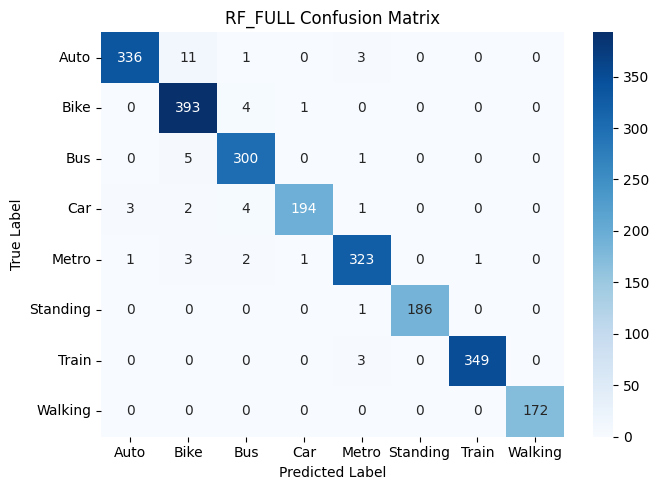

In [42]:
rf_full = rf_model.fit(X_train, y_train)
dump(rf_full, 'temp/RF_FULL.pkl')
log_model(rf_full,X_test,y_test,"RF_FULL")

In [ ]:
visualize_shap_per_class(rf_full, X_train, le)


=== RF_DT ===
Accuracy: 0.9435
5-fold CV accuracy: 0.9807 ± 0.0024

Classification Report:
              precision    recall  f1-score   support

        Auto       0.90      0.91      0.91       351
        Bike       0.91      0.91      0.91       398
         Bus       0.89      0.92      0.91       306
         Car       0.96      0.94      0.95       204
       Metro       0.95      0.95      0.95       331
    Standing       1.00      0.99      1.00       187
       Train       1.00      0.99      0.99       352
     Walking       0.99      0.98      0.99       172

    accuracy                           0.94      2301
   macro avg       0.95      0.95      0.95      2301
weighted avg       0.94      0.94      0.94      2301


Confusion Matrix


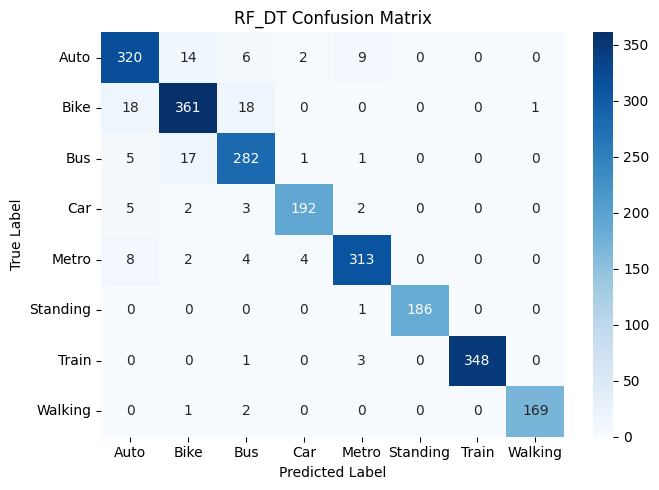

In [43]:
rf_dt = rf_model.fit(X_train_dt,y_train_dt)
dump(rf_dt,'temp/RF_DT.pkl')
log_model(rf_dt,X_test_dt,y_test_dt,"RF_DT")

In [ ]:
visualize_shap_per_class(rf_dt, X_train_dt, le)


=== XGB_FULL ===
Accuracy: 0.9974
5-fold CV accuracy: 0.9941 ± 0.0027

Classification Report:
              precision    recall  f1-score   support

        Auto       1.00      1.00      1.00       351
        Bike       1.00      1.00      1.00       398
         Bus       1.00      1.00      1.00       306
         Car       1.00      0.99      0.99       204
       Metro       0.99      0.99      0.99       331
    Standing       1.00      1.00      1.00       187
       Train       1.00      1.00      1.00       352
     Walking       1.00      1.00      1.00       172

    accuracy                           1.00      2301
   macro avg       1.00      1.00      1.00      2301
weighted avg       1.00      1.00      1.00      2301


Confusion Matrix


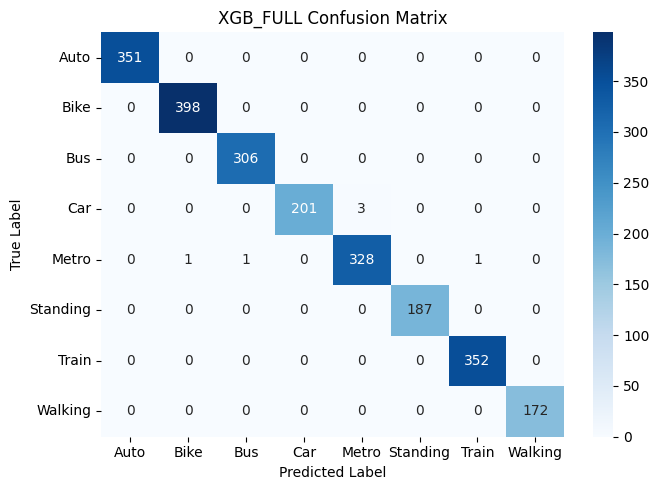

In [ ]:
xgb_full = xgb_model.fit(X_train, y_train)
dump(xgb_full,'temp/XGB_FULL.pkl')
log_model(xgb_full,X_test,y_test,"XGB_FULL")

In [ ]:
visualize_shap_per_class(xgb_full, X_train, le)


=== XGB_DT ===
Accuracy: 0.9878
5-fold CV accuracy: 0.9941 ± 0.0027

Classification Report:
              precision    recall  f1-score   support

        Auto       0.98      0.97      0.98       351
        Bike       0.98      0.98      0.98       398
         Bus       0.99      0.99      0.99       306
         Car       1.00      0.98      0.99       204
       Metro       0.97      0.99      0.98       331
    Standing       1.00      0.99      1.00       187
       Train       1.00      1.00      1.00       352
     Walking       1.00      0.99      1.00       172

    accuracy                           0.99      2301
   macro avg       0.99      0.99      0.99      2301
weighted avg       0.99      0.99      0.99      2301


Confusion Matrix


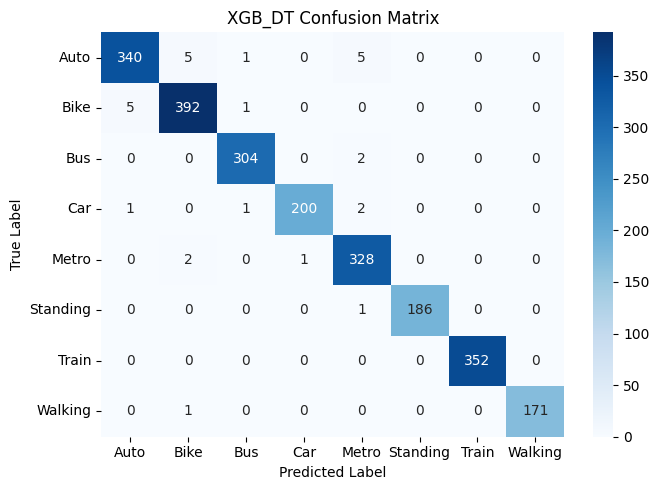

In [21]:
xgb_dt = xgb_model.fit(X_train_dt,y_train_dt)
dump(xgb_dt,'temp/XGB_DT.pkl')
log_model(xgb_dt,X_test_dt,y_test_dt,"XGB_DT")

In [ ]:
visualize_shap_per_class(xgb_dt, X_train_dt, le)

In [22]:
variant = {
    'FULL': (X_train, y_train,X_test,y_test),
    'DT': (X_train_dt,y_train_dt,X_test_dt,y_test_dt)
}
models = {
    'RF': rf_model,
    'XGB': xgb_model
}

In [ ]:
model_variants_records = []
for model_name, model in models.items():
    for variant_name, (Xr,yr,Xt,yt) in variant.items():
      model_variants_records.append(evaluate_model(model, Xr, yr, Xt, yt, f"{model_name}_{variant_name}"))


In [24]:
pd.DataFrame(model_variants_records)

,model_variant,n_features,train_time_s,train_cpu_s,train_energy_Wh,test_time_s,test_cpu_s,test_energy_Wh,accuracy
0,RF_FULL,88,0.731226,8.484375,0.142422,0.057213,0.109375,0.001902,0.979140
1,RF_DT,10,0.359820,2.468750,0.041646,0.041132,0.078125,0.001359,0.943503
2,XGB_FULL,88,4.820460,54.015625,0.906955,0.010152,0.171875,0.002879,0.997392
3,XGB_DT,10,1.398370,15.140625,0.254286,0.010706,0.171875,0.002879,0.987831


## TESTING

In [ ]:
RF_FULL = load('temp/RF_FULL.pkl')
RF_DT = load('temp/RF_DT.pkl')
XGB_FULL = load('temp/XGB_FULL.pkl')
XGB_DT = load('temp/XGB_DT.pkl')
label_encoder = load('temp/label_encoder.pkl')

In [ ]:
predict_model = {
    'RF_FULL' : RF_FULL,
    'RF_DT' : RF_DT,
    'XGB_FULL' : XGB_FULL,
    'XGB_DT' : XGB_DT
}

In [ ]:
test = pd.read_csv('../datasets/filtered_activity_data.csv')
test = test[sensor_features]

In [ ]:
test.value_counts('Activity')

In [ ]:
test_df = extract_features(test)

In [ ]:
test_X = test_df.drop('Activity', axis=1)
test_y = test_df['Activity']
testX_dt = test_X[top_dt_cols.index]
test_y = label_encoder.transform(test_y)

In [ ]:
result = []
for name,model in predict_model.items():
    if 'DT' in name:
        pred_y = model.predict(testX_dt)
    else:   
        pred_y = model.predict(test_X)
    # plot_confusion_matrix(test_y, pred_y, f"{name}_Test", label_encoder)
    result.append([name,accuracy_score(test_y, pred_y)])

In [ ]:
pd.DataFrame(result)

In [ ]:
pred_y = RF_FULL.predict(test_X)
print(accuracy_score(test_y, pred_y))
# plot_confusion_matrix(test_y, pred_y, "RF (Full) - Test", label_encoder)

In [ ]:
pred_y = RF_DT.predict(testX_dt)
print(accuracy_score(test_y, pred_y))
# plot_confusion_matrix(test_y, pred_y, "RF (DT) - Test", label_encoder)

In [ ]:
pred_y = XGB_FULL.predict(test_X)
print(accuracy_score(test_y, pred_y))
# plot_confusion_matrix(test_y, pred_y, "XGB (FULL) - Test", label_encoder)

In [ ]:
pred_y = XGB_DT.predict(testX_dt)
print(accuracy_score(test_y, pred_y))
# plot_confusion_matrix(test_y, pred_y, "XGB (DT) - Test", label_encoder)

## Based on raw data

In [ ]:
X = df.drop('Activity', axis=1)
y = df['Activity']

In [ ]:
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,  # for reproducibility
    shuffle=True,     # shuffling the data
    stratify=y       # maintain class distribution
)
# Verify shapes
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")     # maintain class distribution

In [ ]:
def evaluate_model(model, X, y, title, label_encoder, do_cv=True):
    print(f"\n--- {title} Evaluation ---")
    if do_cv:
        cv_scores = cross_val_score(model, X, y, cv=5)
        print(f"Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    y_pred = model.predict(X)
    print("Accuracy Score:", accuracy_score(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred, target_names=label_encoder.classes_))

# Define confusion matrix plotting function
def plot_confusion_matrix(y_true, y_pred, title, label_encoder):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Evaluate on training set (with CV)
evaluate_model(rf, X_train, y_train, "Training (Random Forest)", le, do_cv=True)

# Evaluate on test set (without CV)
evaluate_model(rf, X_test, y_test, "Test (Random Forest)", le, do_cv=False)

# Plot confusion matrix
rf_test_pred = rf.predict(X_test)
plot_confusion_matrix(y_test, rf_test_pred, "Random Forest", le)

In [ ]:


# Initialize XGBoost Classifier
xgb = XGBClassifier(
    learning_rate=0.05,
    max_depth=2,
    n_estimators=100,
    subsample=0.4,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Train model
xgb.fit(X_train, y_train)

# Evaluate on training set
evaluate_model(xgb, X_train, y_train, "Training (XGBoost)", le, do_cv=True)

# Evaluate on test set
evaluate_model(xgb, X_test, y_test, "Test (XGBoost)", le, do_cv=False)

# Confusion matrix
xgb_test_pred = xgb.predict(X_test)
plot_confusion_matrix(y_test, xgb_test_pred, "XGBoost", le)
